In [1]:
import os
import numpy as np
import pandas as pd
import random
import string
from itertools import groupby

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and visualization Data

In [3]:
train_csv = pd.read_csv(r'D:\handwritten\written_name_train_v2.csv')
val_csv = pd.read_csv(r'D:\handwritten\written_name_validation_v2.csv')
train_img_dir = r'D:\handwritten\train_v2\train'
val_img_dir = r'D:\handwritten\validation_v2\validation'
print(train_csv.shape[0], val_csv.shape[0])
train_csv.head(5)

330961 41370


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


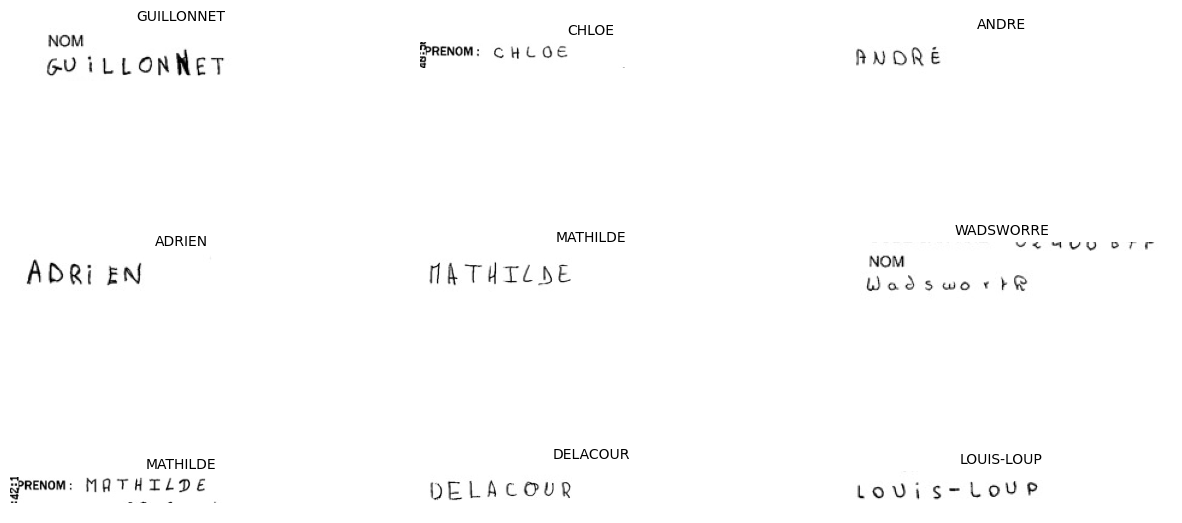

In [4]:
def visualization_data(data_csv, image_dir):
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))

    # Loop over the random images and plot the bounding boxes
    for i in range(9):
        row = i // 3
        col = i % 3

        idx = random.randint(0, 1000)
        # Load the image
        image_path = os.path.join(image_dir, data_csv.loc[idx, 'FILENAME'])
        image = cv2.imread(image_path, 0)
        axs[row, col].imshow(image, cmap = 'gray')
        axs[row, col].set_title(data_csv.loc[idx, 'IDENTITY'], fontsize=10)
        axs[row, col].axis('off')
    plt.show()

visualization_data(train_csv, train_img_dir)

In [5]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE'].sample(frac=0.3, random_state=42)
val_csv = val_csv[val_csv['IDENTITY'] != 'UNREADABLE'].sample(frac=0.3, random_state=42)

print(train_csv.shape[0], val_csv.shape[0])


99258 12407


In [6]:
alphabets = string.ascii_uppercase + "' -"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64 # max length of predicted labels: 64
batch_size = 512

def encode_to_label(text):
    # Encoding each output word into digits
    dig_list = []
    for char in str(text):
        idx = alphabets.find(char)
        dig_list.append(idx if idx!=-1 else alphabets.find('-'))

    return pad_sequences([dig_list], maxlen=max_str_len, padding='post', value=-1)[0]

name = 'QUY DAU'
print(name, '\n', encode_to_label(name))

QUY DAU 
 [16 20 24 27  3  0 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [7]:
def decode_to_text(number_arr):
    text = ''
    for number in number_arr:
        if number == -1: # CTC blank
            break
        else:
            text += alphabets[number]

    return text

decode_to_text([16, 20, 24, 27, 3, 0, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

'QUY DAU'

In [8]:
@tf.function
def preprocess_image(image_path, label, label_len):
    # Read image
    file = tf.io.read_file(image_path)
    # Decode and convert to grayscale
    image = tf.image.decode_png(file, channels=1)
    # Convert to float32 in [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image
    image = tf.image.resize(image, [64, 256])
    # Compute the input_len
    input_len = [num_of_timestamps - 2]

    return image, label, input_len, label_len, [0]

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function for Create list of image data
def create_data_list(data_csv, img_dir):
    data_x, data_y, label_len = [], [], []
    for idx, row in data_csv.iterrows():
        if isinstance(row['IDENTITY'], str):
            data_x.append(os.path.join(img_dir, row['FILENAME']))
            text = row['IDENTITY'].upper()
            data_y.append(encode_to_label(text))
            label_len.append(len(text))

    return data_x, data_y, label_len

# Function for Create tensorflow dataset
def create_tf_dataset(data_x, data_y, label_len):
    dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y, label_len))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
    dataset = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [10]:
# Create tensorflow Dataset for train data
train_x, train_y, train_label_len = create_data_list(train_csv, train_img_dir)
train_dataset = create_tf_dataset(train_x, train_y, train_label_len)

# Create tensorflow Dataset for val data
val_x, val_y, val_label_len = create_data_list(val_csv, val_img_dir)
val_dataset = create_tf_dataset(val_x, val_y, val_label_len)

print(len(train_y), len(val_y))

99108 12385


In [11]:
# Defining the CTC loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [12]:
# Define the Convolutional Block
def conv_block(num_filters, use_max_pool=True, pool_size=(4, 2), stride=2):
    cnn = Sequential()
    cnn.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=pool_size, strides=stride))
    return cnn

# Define the CRNN Model
def CRNN():
    # Inputs
    inputs = Input(shape=(64, 256, 1), name='image')
    labels = Input(name="label", shape=(None,), dtype="float32")
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    # CNN
    conv1 = conv_block(32)(inputs)
    conv2 = conv_block(64)(conv1)
    conv3 = conv_block(128, pool_size=(4, 1), stride=1)(conv2)
    conv4 = conv_block(256, pool_size=(4, 1), stride=1)(conv3)
    conv5 = conv_block(128, pool_size=(5, 1), stride=1)(conv4)

    # CNN --> RNN
    reshape = Reshape((num_of_timestamps, 512))(conv5)
    dense = Dense(num_of_timestamps, activation='relu')(reshape)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.2)(bn)

    # RNN
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(dropout)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(lstm1)

    # Outputs
    y_pred = Dense(num_of_characters, activation = 'softmax')(lstm2)
    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    pred_model = Model(inputs=inputs, outputs=y_pred)
    train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)

    return pred_model, train_model

model, train_model = CRNN()
train_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 64, 256, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 31, 128, 32)       │             448 │ image[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_1 (Sequential)     │ (None, 14, 64, 64)        │          18,752 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_2 (Sequential)     │ (None, 11, 64, 128)       │          74,368 │ sequential_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_3 (Sequential)     │ (None, 8, 64, 256)        │         296,192 │ sequential_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_4 (Sequential)     │ (None, 4, 64, 128)        │         295,552 │ sequential_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 64, 512)           │               0 │ sequential_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64, 64)            │          32,832 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_5         │ (None, 64, 64)            │             256 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64, 64)            │               0 │ batch_normalization_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 64, 128)           │          66,048 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 64, 128)           │          98,816 │ bidirectional[0][0]        │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64, 30)            │           3,870 │ bidirectional_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label (InputLayer)            │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_length (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label_length (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 887,134 (3.38 MB)

 Trainable params: 885,790 (3.38 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K  # Correct import

# ✅ Fix: Import ctc_batch_cost from tensorflow.keras.backend
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)  # Corrected

# ✅ Make sure train_model is compiled properly before training
train_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},  
                    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0))

# ✅ Add EarlyStopping to prevent overfitting
earlyStopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)

# ✅ Train the model
history = train_model.fit(train_dataset,
                          epochs=5,
                          validation_data=val_dataset,
                          verbose=1,
                          shuffle=True,
                          callbacks=[earlyStopping])

# ✅ Save the trained model
train_model.save('my_model.h5')

print("✅ Model training completed and saved successfully!")


Epoch 1/5

194/194 ━━━━━━━━━━━━━━━━━━━━ 1217s 6s/step - loss: 42.4717 - val_loss: 44.3871
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 1136s 6s/step - loss: 11.0654 - val_loss: 34.0464
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 1150s 6s/step - loss: 5.5199 - val_loss: 22.7343
Epoch 4/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 1442s 7s/step - loss: 4.1852 - val_loss: 9.5426
Epoch 5/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 2047s 11s/step - loss: 3.5607 - val_loss: 13.6740


✅ Model training completed and saved successfully!


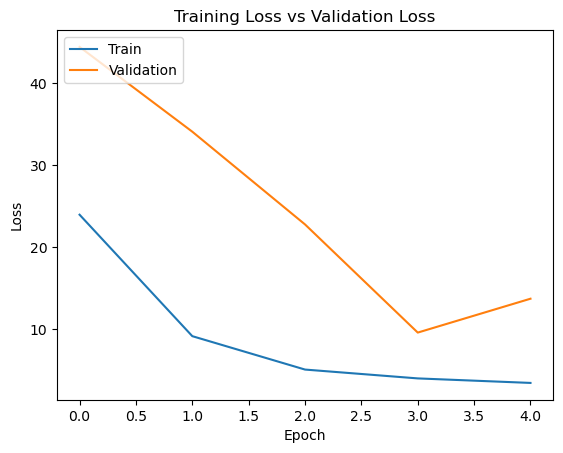

In [16]:
# Visualize the training process

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
# Load the best model
model.load_weights(r'D:\handwritten\my_model.h5')

In [24]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []

    pred_indices = np.argmax(predictions, axis=2)

    for i in range(pred_indices.shape[0]):
        ans = ""

        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indices[i])]

        ## remove blanks
        for p in merged_list:
            if p != len(alphabets):
                ans += alphabets[int(p)]

        text_list.append(ans)

    return text_list

In [26]:
def get_predictions_and_labels(dataset, model):
    """
    Input: Tensorflow Dataset and the model to predict
    Output: Extract labels from dataset and get prediction from the model
    """
    predictions, labels = [], []
    for batch in dataset.as_numpy_iterator():
        images, num_labels = batch[0][0], batch[0][1]
        preds = model.predict(images)
        predictions.extend(ctc_decoder(preds))
        labels.extend([decode_to_text(num_labels[i]) for i in range(len(num_labels))])

    return predictions, labels

predictions, labels = get_predictions_and_labels(val_dataset, model)
print(len(predictions), len(labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
1

In [27]:
def get_accuracy_characters_and_words(predictions, labels):
    """
    Input: The predictions and labels text of validation data
    Output: The accuracy about words and characters
    """
    word_accuracy = np.mean([predictions[i] == labels[i] for i in range(len(predictions))])
    num_correct_char, len_char = 0, 0
    for i in range(len(predictions)):
        num_correct_char += np.sum([predictions[i][j] == labels[i][j] for j in range(min(len(predictions[i]), len(labels[i])))])
        len_char += len(labels[i])

    character_accuracy = num_correct_char/ float(len_char)
    return word_accuracy, character_accuracy

word_accuracy, character_accuracy = get_accuracy_characters_and_words(predictions, labels)
print('Character accuracy in the validation set: {} %'.format(round(character_accuracy * 100, 3)))
print('Word accuracy in the validation set: {} %'.format(round(word_accuracy * 100, 3)))

Character accuracy in the validation set: 29.809 %
Word accuracy in the validation set: 2.067 %


In [34]:
# Declare image directory and label csv file for the test dataset
test_img_dir = r'D:\handwritten\test_v2\test'
test_csv = pd.read_csv(r'D:\handwritten\written_name_test_v2.csv')

# Create test dataset with TensorFlow format
test_x, test_y, test_label_len = create_data_list(test_csv, test_img_dir)
test_dataset = create_tf_dataset(test_x, test_y, test_label_len)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


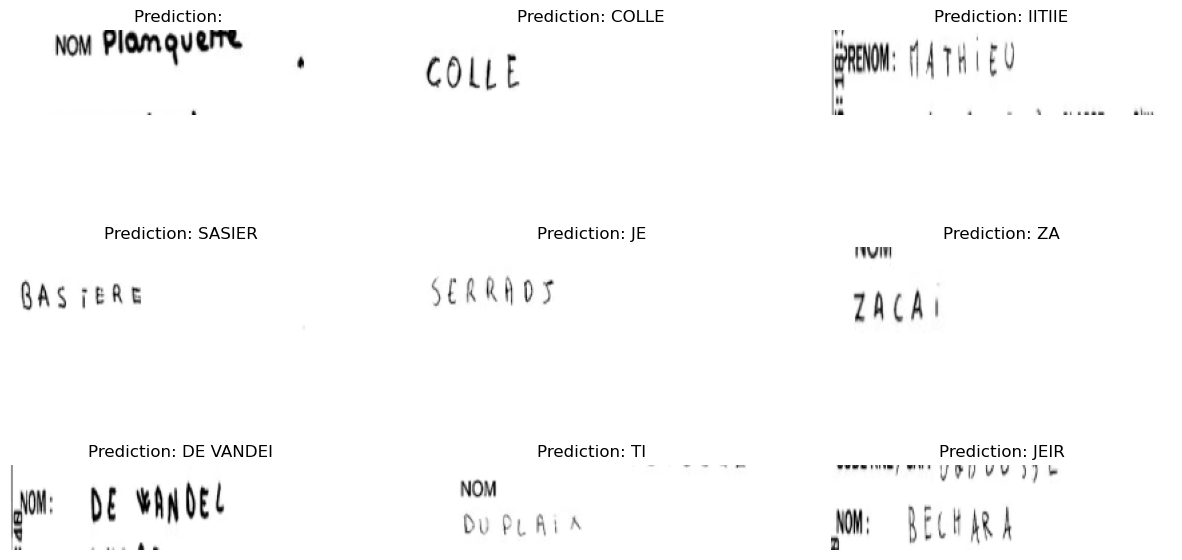

In [35]:
def test_images_data_with_model_prediction(model, dataset):
    # Create predictions for a batch in this dataset
    for batch in dataset.as_numpy_iterator():
        images = batch[0][0]
        predictions = ctc_decoder(model.predict(images))
        break

    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))

    # Loop over the random images and plot the image with prediction model
    for i in range(9):
        row = i // 3
        col = i % 3

        idx = random.randint(0, batch_size)
        axs[row, col].imshow(images[idx], cmap = 'gray')
        axs[row, col].set_title('Prediction: {}'.format(predictions[idx]), fontsize=12)
        axs[row, col].axis('off')
    plt.show()

test_images_data_with_model_prediction(model, test_dataset)

In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image



def predict_image(image):
    # Preprocess the image to match dataset format
    image = image.convert("L")  # Convert to grayscale
    image = image.resize((256, 64))  # Resize to match model input shape
    image_array = np.array(image) / 255.0  # Normalize
    image_array = np.expand_dims(image_array, axis=(0, -1))  # Add batch and channel dims
    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)  # Convert to Tensor
    
    # Model prediction
    prediction = model(image_tensor, training=False)  # Ensure model runs in inference mode
    decoded_prediction = ctc_decoder(prediction)  # Decode the CTC output
    return decoded_prediction[0]

# Gradio Interface
demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Predicted Text"),
    title="Image Text Recognition",
    description="Upload an image and get the model's text prediction."
)

demo.launch(debug=True)


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
